In [4]:
from collections import defaultdict, deque, Counter
import random
import numpy as np
import os
from typing import *
from tqdm import tqdm
import networkx as nx
from matplotlib import pyplot as plt

DEFAULT_DATA_FOLDER = "./networks"

In [5]:
def read(filepath):
    G = nx.Graph()
    with open(filepath, 'r', encoding="utf-8") as file:
        line = file.readline()
        n = int(line.strip().split(" ")[1])
        for _ in range(n):
            parts = file.readline().strip().split("!")
            id = int(parts[0])
            name = parts[1]
            label = parts[2].strip()
            G.add_node(id, name=name, label=label)
        line = file.readline()
        m = int(line.strip().split(" ")[1])
        for _ in range(m):
            parts = file.readline().strip().split(" ")
            G.add_edge(int(parts[0]), int(parts[1]))
    return nx.convert_node_labels_to_integers(G)


filepath = "works.net"
G = read(filepath)
n = G.number_of_nodes()
m = G.number_of_edges()
G.name = "works"
print(n)
print(m)

6475
31070


In [6]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def info(G: nx.Graph, distance_sample: int | None = None,
         clustering_sample: int | None = 10_000) -> None:
    """Prints basic information on the provided graph.
    - If distance_sample is given, distance statistics will be computed from
    a sample of nodes (of given size).
    - If clustering_sample is given, average clustering will be computed from
    a sample of nodes (of given size).
    """
    print("{:>12s} | '{:s}'".format(str(G).split()[0], G.name))

    n = G.number_of_nodes()
    m = G.number_of_edges()

    print("{:>12s} | {:,d} (iso={:,d})".format(
        'Nodes', n, nx.number_of_isolates(G)))
    print("{:>12s} | {:,d} (loop={:,d})".format(
        'Edges', m, nx.number_of_selfloops(G)))

    if G.is_directed():
        print("{:>12s} | {:.2f} max(in={:d}, out={:d})".format(
            'Degree', m / n, max(k for _, k in G.in_degree()),
            max(k for _, k in G.out_degree())))
    else:
        print("{:>12s} | {:.2f} (max={:,d})".format(
            'Degree', 2 * m / n, max((k for _, k in G.degree()))))

    C = list(nx.connected_components(nx.Graph(G) if G.is_directed else G))
    largest_comp = max(C, key=len)

    print("{:>12s} | {:.1f}% (n={:,d})".format(
        'LCC', 100 * len(largest_comp) / n, len(C)))

    if distance_sample is not None:
        G_lcc = G.subgraph(largest_comp)
        if n <= distance_sample:
            mean = nx.average_shortest_path_length(G_lcc)
            diam = nx.diameter(G_lcc)
        else:
            D = distances(G_lcc, n=distance_sample)
            mean = np.mean(D)
            diam = max(D)

        print("{:>12s} | {:.2f} (max={:,d})".format('Distance', mean, diam))

    if clustering_sample is not None:
        if isinstance(G, nx.MultiGraph):
            G = nx.Graph(G)

        clustering_on = G.nodes if n <= clustering_sample \
            else random.sample(list(G.nodes), k=clustering_sample)

        print("{:>12s} | {:.4f}".format(
            'Clustering', nx.average_clustering(G, clustering_on)))
    print()

In [7]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def plot_degree(G: nx.Graph, save_path: str | None = None) -> None:
    """Plots degree distribution(s) on a log-log plot.
    If save_path is given, the plot will be saved in given folder/file
    instead of being shown."""
    plt.clf()
    plt.title(G.name + " degree distribution")
    plt.ylabel('$p_k$')
    plt.xlabel('$k$')
    n = G.number_of_nodes()

    def aux(degree_view: Iterable, k_min: int, **kwargs):
        degree_count = Counter(k for _, k in degree_view)
        k_max = max(degree_count.keys())

        x = list(range(k_min, k_max + 1))
        y = [degree_count[i] / n for i in x]
        plt.loglog(x, y, 'o', **kwargs)

    if G.is_directed():
        aux(G.out_degree, k_min=0, label="outdegree", color="pink")
        aux(G.in_degree, k_min=0, label="indegree", color="purple", alpha=0.5)
        plt.legend()
    else:
        aux(G.degree, k_min=1, color="gray")

    if save_path is None:
        plt.show()
    else:
        if len(os.path.splitext(save_path)[1]) == 0: # no extension
            plt.savefig(os.path.join(save_path, f"{G.name}_degree_distro.pdf"))
        else:
            plt.savefig(save_path)

       Graph | 'works'
       Nodes | 6,475 (iso=81)
       Edges | 31,070 (loop=0)
      Degree | 9.60 (max=6,082)
         LCC | 98.7% (n=82)
  Clustering | 0.0000



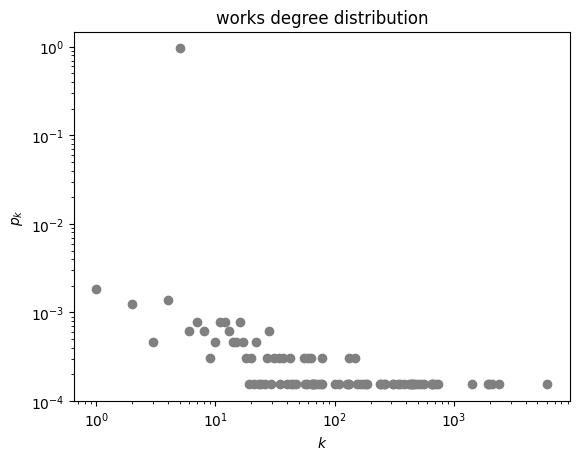

In [8]:
info(G)
plot_degree(G)

In [9]:
def find_node(G: nx.Graph, label: str):
    """Finds node with given label in G."""
    for i, data in G.nodes(data=True):
        if data['name'] == label:
            return i
    raise ValueError(f"node '{label}' not found in {G.name}")

In [10]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def top_nodes(G: nx.Graph, C: Dict[Any, float], centrality: str, n=15, filter=[], output=True) -> List[Any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    if output:
        print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    values = []
    filtered = C.items()
    if len(filter) > 0:
        filtered = [(node, pr) for node, pr in filtered if G.nodes[node]['label'] in filter]
    for i, c in sorted(filtered, key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        # if G.nodes[i]['label'] == 'Key':
        nodes.append(G.nodes[i]['name'])
        values.append(c)
        if output:
            print("{:>12.6f} | '{:s}' ({:,d}) '{:s}'".format(
                c, G.nodes[i]['label'], G.degree[i], G.nodes[i]['name'][:30]))
        n -= 1
        if n == 0:
            break
    print()
    return nodes, values


def nodes_names(nodes) -> List[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names


In [11]:
def pagerank(G: nx.Graph, alpha=0.85, eps=1e-6, teleport: list | None=None, weights: list | None=None):
    P = [1 / len(G)] * len(G)
    diff = 1
    # If weights is not none, put appropriate weight on the nodes,
    # inversely proportional to their degree
    while diff > eps:
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]])
             for i in G.nodes()]
        u = sum(U)
        if teleport is not None:
            if weights is not None:
                for ix, i in enumerate(teleport):
                    w = weights[ix] * (1-u)
                    U[i] += w
            else:
                for i in teleport:
                    U[i] += (1 - u) / len(teleport)
        else:
            U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

In [12]:
def calculate_pr_weights(G, biased=False):
    popular = find_node(G, "Popular")
    all_popular = list(G.neighbors(popular))
    all_keys = [node['name'] for ix, node in G.nodes(data=True) if node['label'] == 'Key']
    node_to_key = {}
    key_to_degree = {key: 0 for key in all_keys}
    for node in all_popular:
        for n in G.neighbors(node):
            if G.nodes(data=True)[n]['label'] == 'Key':
                node_to_key[node] = G.nodes(data=True)[n]['name']
                key_to_degree[G.nodes(data=True)[n]['name']] += 1
    weights = [key_to_degree[node_to_key[node]] if key_to_degree[node_to_key[node]] != 0 else 0 for node in all_popular]
    #print(weights)
    weights2 = [sum(key_to_degree.values())/w for w in weights]
    #print(weights2)
    if biased:
        weights2 = [w**2 for w in weights2]
        #print(weights2)
    weights3 = [w/sum(weights2) for w in weights2]
    #print(weights3)
    #for w, f, frac in zip(weights, weights2, weights3):
    #    print(f"{w}, {f}, {frac}")
    return weights3

weights = calculate_pr_weights(G)
biased_weights = calculate_pr_weights(G, biased=True)

In [13]:
# Use weighted pagerank
popular_node = find_node(G, "Popular")
nonpopular_node = find_node(G, "Nonpopular")
#print(G.nodes(data=True)[popular_node])
popular_neighbors = list(G.neighbors(popular_node))

C = pagerank(G, alpha=0.7, teleport=popular_neighbors)
x1, y1 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'], output=True)
C = pagerank(G, alpha=0.7, teleport=popular_neighbors, weights=weights)
x2, y2 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'], output=True)

  Centrality | 'Pagerank'
    0.007874 | 'Key' (659) 'D major'
    0.007783 | 'Key' (654) 'C major'
    0.007453 | 'Key' (420) 'G minor'
    0.006821 | 'Key' (438) 'D minor'
    0.006787 | 'Key' (458) 'E flat major'
    0.005948 | 'Key' (309) 'C minor'
    0.005373 | 'Key' (472) 'F major'
    0.004844 | 'Key' (351) 'A minor'
    0.004713 | 'Key' (531) 'G major'
    0.004441 | 'Key' (501) 'B flat major'
    0.004327 | 'Key' (247) 'E minor'
    0.003807 | 'Key' (383) 'A major'
    0.002802 | 'Key' (153) 'B minor'
    0.002436 | 'Key' (174) 'E major'
    0.002371 | 'Key' (149) 'F minor'
    0.001343 | 'Key' (22) 'B flat minor'
    0.000791 | 'Key' (67) 'A flat major'
    0.000707 | 'Key' (64) 'F sharp minor'
    0.000669 | 'Key' (42) 'C sharp minor'
    0.000595 | 'Key' (37) 'D flat major'
    0.000167 | 'Key' (28) 'F sharp major'
    0.000136 | 'Key' (28) 'B major'
    0.000121 | 'Key' (20) 'E flat minor'
    0.000043 | 'Key' (7) 'G sharp minor'

  Centrality | 'Pagerank'
    0.005907 | 

# Graph with randomly distributed edges

In [14]:
def get_randomized_graph(G):
    G_randomized = nx.Graph()
    G_randomized.name = "randomized attributes"
    G_randomized.add_nodes_from(G.nodes(data=True))
    G_randomized.nodes(data=True)
    type_of_nodes = {'Composer': (0, 219), 'Period': (220, 229), 'Popularity': (230, 231), 'Genre': (232, 236), 'Key': (237, 260), 'Work': (261, 6474)}
    for work in range(type_of_nodes['Work'][0], type_of_nodes['Work'][1] + 1):
        for attr in G[work]:
            label = G.nodes[attr]['label']
            edge_end = random.randint(type_of_nodes[label][0], type_of_nodes[label][1])
            G_randomized.add_edge(work, edge_end)
    return G_randomized

In [15]:
G_rand = get_randomized_graph(G)
labels = ['C major','D flat major','D major','E flat major','E major','F major','F sharp major','G major','A flat major','A major','B flat major','B major','C minor','C sharp minor','D minor','E flat minor','E minor','F minor','F sharp minor','G minor','G sharp minor','A minor','B flat minor','B minor']

In [16]:
def plot_popularities(x, y1, y2, label1, label2, title):
    N = len(x)
    ind = np.arange(N)
    width = 0.3

    plt.figure()
    plt.bar(ind, y1, width, label=label1, color='deepskyblue', edgecolor='black')
    plt.bar(ind+width, y2, width, label=label2, color='salmon', edgecolor='black')

    plt.title(title)
    plt.xlabel('Key')
    plt.ylabel('Popularity')

    plt.xticks(ind+width/2, x, rotation='vertical')
    plt.legend(loc='best')
    plt.show()

#plot_popularities(labels, y1, y2, 'Original graph', 'Randomized graph', 'Key popularity in entire dataset')

In [21]:
def scale_second_to_first(v1, v2):
    rmin = min(v2)
    rmax = max(v2)
    tmin = min(v1)
    tmax = max(v1)
    return [(m-rmin)*(tmax-tmin)/(rmax-rmin) + tmin for m in v2]

def calculate_pagerank_without_degree(G, y1, labels):
    degrees = [G.degree(find_node(G, key)) for key in labels]
    y2 = scale_second_to_first(y1, degrees)
    diffs = [a-0.8*b for a,b in zip(y1, y2)]
    diff_min = min(diffs)
    return [d-diff_min for d in diffs]

def calculate_pagerank_without_degree_random(y, degrees):
    y2 = scale_second_to_first(y, degrees)
    diffs = [a-0.8*b for a,b in zip(y1, y2)]
    diff_min = min(diffs)
    return [d-diff_min for d in diffs]

def get_random_pagerank(G, alpha, teleport, labels, iters=10):
    combined_y = np.zeros(len(labels))
    combined_degrees = np.zeros(len(labels))
    for i in range(iters):
        G2 = get_randomized_graph(G)
        pr = pagerank(G2, alpha=alpha, teleport=teleport)
        x1, y1 = top_nodes(G2, pr, 'Pagerank', n=40, filter=['Key'], output=False)
        y1 = np.array([y1[x1.index(n)] for n in labels])
        combined_y += y1
        # Get degrees
        combined_degrees += np.array([G2.degree(find_node(G2, lab)) for lab in labels]) 
    return combined_y / iters, combined_degrees/iters


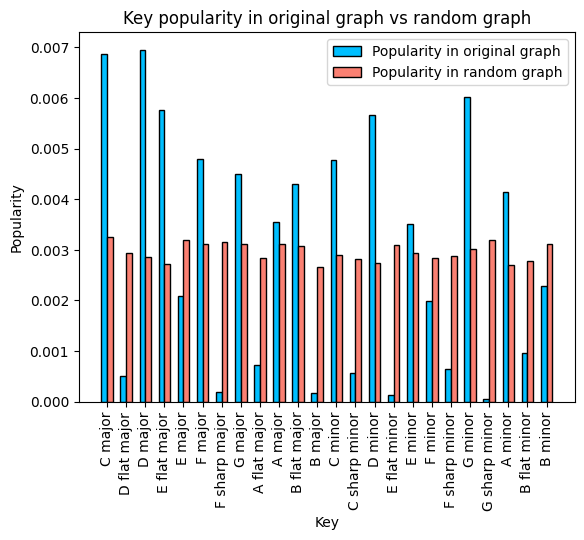

In [26]:
# Calculate correlation between node degree and pagerank popularity
C = pagerank(G, alpha=0.8, teleport=[popular_node])
x1, y1 = top_nodes(G, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y1 = [y1[x1.index(n)] for n in labels]

C = pagerank(G_rand, alpha=0.8, teleport=[popular_node])
x2, y2 = top_nodes(G_rand, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y2 = [y2[x2.index(n)] for n in labels]
#y2, degrees = get_random_pagerank(G, alpha=0.8, teleport=[popular_node], labels=labels)
#y2 = calculate_pagerank_without_degree_random(y1, degrees)
#y2 = scale_second_to_first(y1, y2)
plot_popularities(labels, y1, y2, 'Popularity in original graph', 'Popularity in random graph', 'Key popularity in original graph vs random graph')

#plot_popularities(labels, y1, y2, 'Pagerank popularity', 'Node degrees', 'Comparison of pagerank results and node degrees')

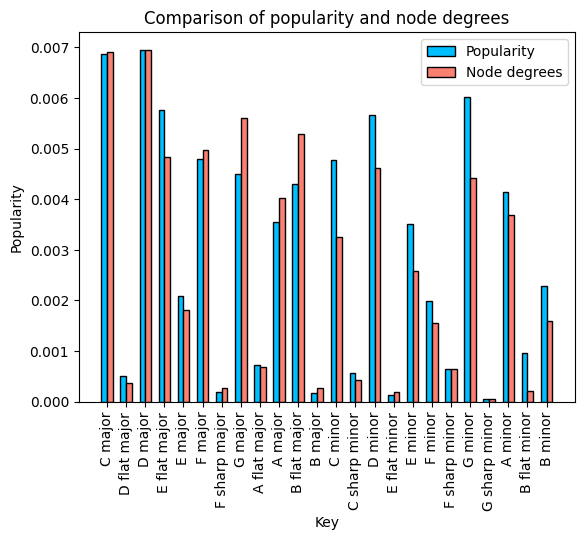

In [28]:
# Show correlation between popularity and degree
C = pagerank(G, alpha=0.8, teleport=[popular_node])
x1, y1 = top_nodes(G, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y1 = [y1[x1.index(n)] for n in labels]

degrees = [G.degree(find_node(G, key)) for key in labels]
y2 = scale_second_to_first(y1, degrees)
plot_popularities(labels, y1, y2, 'Popularity', 'Node degrees', 'Comparison of popularity and node degrees')

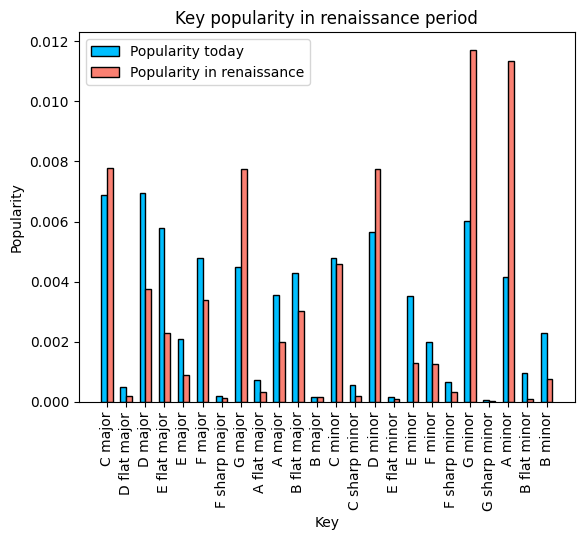

In [30]:
# Calculate popularity for renaissance
C = pagerank(G, alpha=0.8, teleport=[popular_node])
x1, y1 = top_nodes(G, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y1 = [y1[x1.index(n)] for n in labels]

renaissance = find_node(G, "Renaissance")
C = pagerank(G, alpha = 0.8, teleport=[renaissance])
x2, y2 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'], output=False)
y2 = [y2[x2.index(n)] for n in labels]

plot_popularities(labels, y1, y2, 'Popularity today', 'Popularity in renaissance', 'Key popularity in renaissance period')

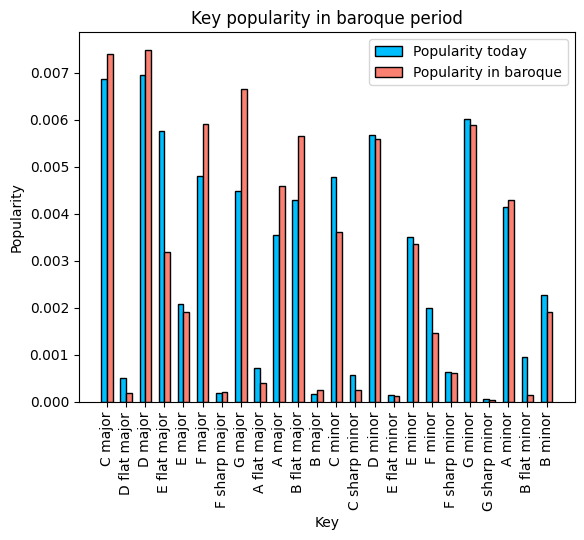

In [32]:
# Calculate popularity for baroque
C = pagerank(G, alpha=0.8, teleport=[popular_node])
x1, y1 = top_nodes(G, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y1 = [y1[x1.index(n)] for n in labels]

baroque = find_node(G, "Baroque")
C = pagerank(G, alpha = 0.8, teleport=[baroque])
x2, y2 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'], output=False)
y2 = [y2[x2.index(n)] for n in labels]

plot_popularities(labels, y1, y2, 'Popularity today', 'Popularity in baroque', 'Key popularity in baroque period')

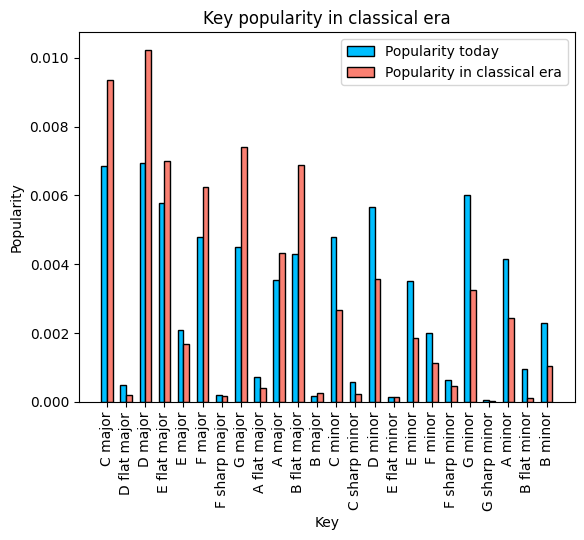

In [33]:
# Calculate popularity for classical
C = pagerank(G, alpha=0.8, teleport=[popular_node])
x1, y1 = top_nodes(G, C, 'Pagerank',  n=40, filter=['Key'], output=False)
y1 = [y1[x1.index(n)] for n in labels]

classical = find_node(G, "Classical")
C = pagerank(G, alpha = 0.8, teleport=[classical])
x2, y2 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'], output=False)
y2 = [y2[x2.index(n)] for n in labels]

plot_popularities(labels, y1, y2, 'Popularity today', 'Popularity in classical era', 'Key popularity in classical era')

In [37]:
famous_composers = [
'Wolfgang Amadeus Mozart',
'Johann Sebastian Bach',
'Ludwig van Beethoven',
'Frédéric Chopin',
'Claude Debussy',
'Franz Joseph Haydn',
'Franz Liszt',
'Sergei Rachmaninoff',
'Pyotr Ilyich Tchaikovsky',
'Richard Wagner',
]
for c in famous_composers:
    comp = find_node(G, c)
    C = pagerank(G, alpha=0.8, teleport=[comp])
    x1, y1 = top_nodes(G, C, 'Pagerank',  n=1, filter=['Key'], output=True)

Wolfgang Amadeus Mozart
Johann Sebastian Bach
Ludwig van Beethoven
Frédéric Chopin
Claude Debussy
Franz Joseph Haydn
Franz Liszt
Sergei Rachmaninoff
Pyotr Ilyich Tchaikovsky
Richard Wagner

  Centrality | 'Pagerank'
    0.011337 | 'Key' (659) 'D major'

  Centrality | 'Pagerank'
    0.007169 | 'Key' (654) 'C major'

  Centrality | 'Pagerank'
    0.009183 | 'Key' (458) 'E flat major'

  Centrality | 'Pagerank'
    0.006033 | 'Key' (458) 'E flat major'

  Centrality | 'Pagerank'
    0.019476 | 'Key' (420) 'G minor'

  Centrality | 'Pagerank'
    0.010503 | 'Key' (659) 'D major'

  Centrality | 'Pagerank'
    0.007090 | 'Key' (153) 'B minor'

  Centrality | 'Pagerank'
    0.014597 | 'Key' (438) 'D minor'

  Centrality | 'Pagerank'
    0.007072 | 'Key' (659) 'D major'

  Centrality | 'Pagerank'
    0.010338 | 'Key' (654) 'C major'



In [31]:
key_freqs = []
for node in popular_neighbors:
    for n in G.neighbors(node):
        if G.nodes(data=True)[n]['label'] == 'Key':
            key_freqs.append(G.nodes(data=True)[n]['name'])
            break
counter = Counter(key_freqs)
key_degrees = [G.degree(find_node(G, key)) for key in labels]
ratios = [counter[label]/key_degrees[ix] for ix, label in enumerate(labels)]
print(counter)
print(labels)
print(ratios)

Counter({'G minor': 14, 'D major': 12, 'D minor': 12, 'C major': 12, 'C minor': 11, 'E flat major': 11, 'F major': 8, 'A minor': 8, 'E minor': 8, 'G major': 6, 'B flat major': 5, 'A major': 5, 'B minor': 5, 'E major': 4, 'F minor': 4, 'B flat minor': 3, 'C sharp minor': 1, 'A flat major': 1, 'F sharp minor': 1, 'D flat major': 1})
['C major', 'D flat major', 'D major', 'E flat major', 'E major', 'F major', 'F sharp major', 'G major', 'A flat major', 'A major', 'B flat major', 'B major', 'C minor', 'C sharp minor', 'D minor', 'E flat minor', 'E minor', 'F minor', 'F sharp minor', 'G minor', 'G sharp minor', 'A minor', 'B flat minor', 'B minor']
[0.01834862385321101, 0.02702702702702703, 0.018209408194233688, 0.024017467248908297, 0.022988505747126436, 0.01694915254237288, 0.0, 0.011299435028248588, 0.014925373134328358, 0.013054830287206266, 0.00998003992015968, 0.0, 0.03559870550161812, 0.023809523809523808, 0.0273972602739726, 0.0, 0.032388663967611336, 0.026845637583892617, 0.015625,